In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

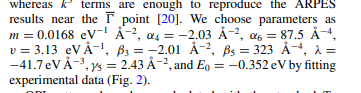

In [2]:
Par = np.array([0.0168, -2.03, 87.5, 3.13, -2.01, 323, -41.7, 2.43, -0.352])

In [3]:
N = 800; #16
om = -0.01;
k_spacex, k_spacey = np.mgrid[-1.5:1.5:N*1j,-1.5:1.5:N*1j]
#k_spacex1, k_spacey1 = np.ogrid[-1.5:1.5:500j,-1.5:1.5:500j]
test = [k_spacex, k_spacey]
var = np.zeros([len(k_spacex),len(k_spacex)])



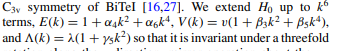

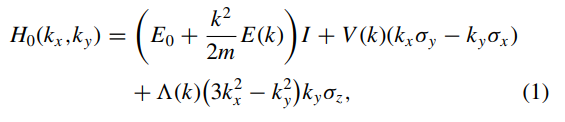

In [4]:
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])

def H(kr, p = Par):
    k_x, k_y = kr
    m, α4, α6, v, β3, β5, λ, γ5, E0 = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x;
    ksq = k_x**2+k_y**2
    Ek = 1+α4*ksq+α6*ksq**2; Vk = v*(1+β3*ksq+β5*ksq**2); Λ = λ*(1+γ5*ksq)
    return (E0+ksq/(2*m)*Ek)*np.eye(2)+Vk*(k_x*σy-k_y*σx)+Λ*(3*k_x**2-k_y**2)*k_y*σz

print(H([0.2,1.1]))

[[ 5230.58049637  +0.j      -1732.431525  -314.98755j]
 [-1732.431525  +314.98755j  4826.84422387  +0.j     ]]


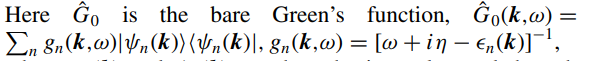

In [5]:
from numpy import linalg as LA
η = 0.01
def G0(k, ω = om):
    kx, ky = k
    Ham = H(k); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2])
    for n in range(len(λ)):
        g = (ω+1j*0.01-λ[n])**(-1)
        ψ = v[n]
        summ = summ+g*np.matmul(np.transpose(ψ), np.conj(ψ))
    return summ
print(G0([0.0,0.0], 0.01))       

[[5.52064906-0.15250412j 5.52064906-0.15250412j]
 [5.52064906-0.15250412j 5.52064906-0.15250412j]]


In [6]:
length = 0.6
k_spacex3, k_spacey3 = np.mgrid[-length:length:N*1j,-length:length:N*1j]

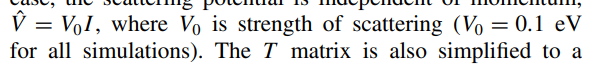

(scalar)

In [7]:
from numpy.linalg import inv
kxx = np.linspace(-length,length, N)
kyy = np.linspace(-length,length, N)
G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mp[i,j] = G0([kxx[i], kyy[j] ], om)

G0-Matrix: 100%|██████████| 800/800 [00:51<00:00, 15.60it/s]


In [8]:
V0 = 0.1
def u(k):
    kx, ky = k
    u1 = np.zeros((3,1,2,2), dtype = 'complex')
    u1 = np.array([[np.eye(2)],[np.eye(2)*kx],[np.eye(2)*ky]])
    return u1

b = np.zeros((2,2))
U = np.array([[V0*np.eye(2),b,b],[b,b,1j*60*σz],[b,-1j*60*σz,b]], dtype= 'complex')

def v(k):
    kx, ky = k
    return np.matmul(U, u(k))

def V(k, k1):
    return np.matmul(u(k).T,v(k1))

def M(ω = om):
    summ = np.zeros((3,3,2,2), dtype = 'complex')
    for i in tqdm(range(N), desc="M-Matrix"):
        for j in range(N):
            summ = summ + np.array([[G0Mp[i,j], kxx[i]*G0Mp[i,j], kyy[j]*G0Mp[i,j]], 
                                      [kxx[i]*G0Mp[i,j], kxx[i]**2*G0Mp[i,j], kxx[i]*kyy[j]*G0Mp[i,j]], [kyy[j]*G0Mp[i,j], kxx[i]*kyy[j]*G0Mp[i,j], kyy[j]**2*G0Mp[i,j]]]) 
    return np.array([[np.matmul(U[0,0], summ[0,0]), np.matmul(U[0,0], summ[0,1]), np.matmul(U[0,0], summ[0,2])], 
                     [np.matmul(U[1,2], summ[2,0]), np.matmul(U[1,2], summ[2,1]), np.matmul(U[1,2], summ[2,2])],
                     [np.matmul(U[2,1], summ[1,0]), np.matmul(U[2,1], summ[1,1]), np.matmul(U[2,1], summ[1,2])]])

M = M(om)
v1 = v([0,0])

M-Matrix: 100%|██████████| 800/800 [00:13<00:00, 59.34it/s]


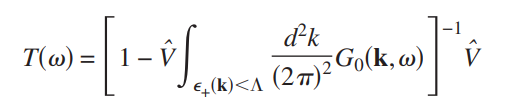

(Momentum-independent)

In [9]:
iter1 = 4   
from numpy.linalg import matrix_power
def T(ω = om, n = iter1):
    summ = np.array([V0*np.eye(2),b,b], dtype= 'complex')
    val = V0*np.eye(2)
    for i in tqdm(range(n), desc="T-Matrix"):
        pow1 = matrix_power(M,n+1)
        summ = summ+np.array([[np.matmul(pow1[0,0],val)],[np.matmul(pow1[1,0],val)],[np.matmul(pow1[2,0],val)]], dtype= 'complex')
    return np.matmul(val, summ[0,0])

T1 = T(om)
print(T1)

T-Matrix: 100%|██████████| 4/4 [00:00<00:00, 2005.88it/s]

[[-2.80435692e+23+9.27062901e+23j -2.80435692e+23+9.27062901e+23j]
 [-2.80435692e+23+9.27062901e+23j -2.80435692e+23+9.27062901e+23j]]


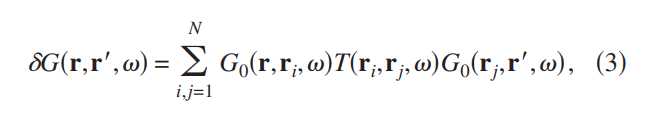
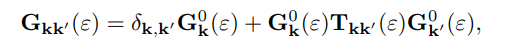

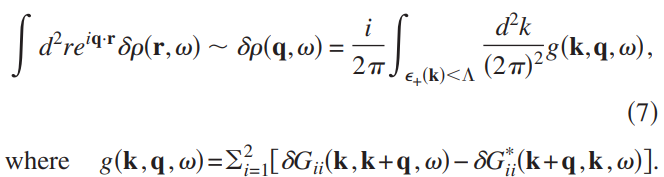

In [10]:
# def DOS(q, ω = om):
#     #G1 = G(k, k+q)
#     #G2 = (-1*G(k+q, k)).getH()
#     summ = 0+0*1j
#     for i in range(N):
#         for j in range(N):
#             k = np.array([k_spacex3[i,j], k_spacey3[i,j]])
#             G0k = G0M[i,j]
#             G0kq = np.roll(G0M, 
#             G0kq1 = G0kq[i,j]
#             G1 = np.trace(G(G0k, G0(k+q, om)))
#             G2 = -1*np.trace(G(G0(k+q, om), G0k).conj().T)
#             summ = summ+G1+G2
#     return np.real(1j*summ/(2*np.pi)**3)
# #go = DOS(np.array([0,1]))
# print(DOS(np.array([0,1])))
print(T1[0,])

[-2.80435692e+23+9.27062901e+23j -2.80435692e+23+9.27062901e+23j]


In [11]:
sol = np.zeros((N,N))


In [12]:
G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mm[i,j] = G0([-1*kxx[i], -1*kyy[j] ], om)
# G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
# for i in tqdm(range(N), desc="G0-Matrix"):
#         for j in range(N):
#             G0Mm[i,j] = G0([-1*k_spacex3[i, j], -1*k_spacey3[i, j] ], om)
            

G0-Matrix: 100%|██████████| 800/800 [01:00<00:00, 13.17it/s]


In [13]:
G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')


            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mpconj[i,j] = G0Mp[i,j].conj()
            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mmconj[i,j] = G0Mp[i,j].conj()



G0-Matrix HT: 100%|██████████| 800/800 [00:01<00:00, 642.98it/s]


In [32]:
#print(G0M[:,:,0,0])
def DOS(w = om):
    fact = 1j/(2*np.pi)**3/N
    res = np.zeros([N,N], dtype = 'complex')

    T2 = T1.conj()
    
    for m in range(2):
        for n in range(2):
            for j in tqdm(range(2), desc="G0-Matrix"):
                Gp1 = (np.fft.fft2(fftshift(G0Mp[:,:,n,j])))
                Gm1 = (np.fft.fft2(fftshift(G0Mm[:,:,j,m])))
                G1 = np.fft.ifft2((np.multiply((Gp1),(Gm1))))
                Gp2 = (np.fft.fft2(fftshift(G0Mpconj[:,:,j,m])))
                Gm2 = (np.fft.fft2(fftshift(G0Mmconj[:,:,n,j])))
                G2 = np.fft.ifft2((np.multiply(Gp2,Gm2)))
            res = res+T1[m,n]*(G1)-(T2[m,n]*(G2))
    
    sol = (np.abs(ifftshift(fact*res)))
    return sol

In [33]:
sol = DOS()
print(sol)

G0-Matrix: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

[[1.09793220e+24 1.09819358e+24 1.09862925e+24 ... 1.09819358e+24
  1.09793220e+24 1.09784508e+24]
 [1.09816533e+24 1.09842681e+24 1.09886264e+24 ... 1.09842681e+24
  1.09816533e+24 1.09807818e+24]
 [1.09855391e+24 1.09881554e+24 1.09925164e+24 ... 1.09881554e+24
  1.09855391e+24 1.09846670e+24]
 ...
 [1.09816533e+24 1.09842681e+24 1.09886264e+24 ... 1.09842681e+24
  1.09816533e+24 1.09807818e+24]
 [1.09793220e+24 1.09819358e+24 1.09862925e+24 ... 1.09819358e+24
  1.09793220e+24 1.09784508e+24]
 [1.09785450e+24 1.09811585e+24 1.09855146e+24 ... 1.09811585e+24
  1.09785450e+24 1.09776739e+24]]


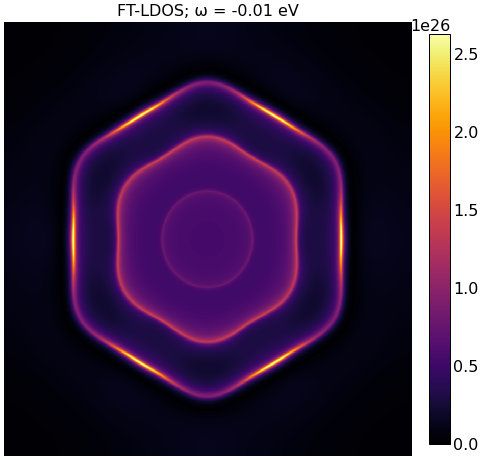

In [36]:
plt.figure(figsize=(8,8))
range1 = 0.0
plt.pcolormesh(k_spacex3/length,k_spacey3/length, sol, cmap = "inferno", shading = 'auto', vmin = range1)
plt.title("FT-LDOS; ω = -0.01 eV")
plt.axis('off')

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('spin QPI 800', bbox_inches='tight')
plt.show()

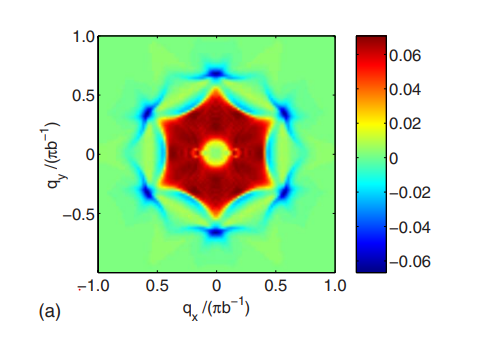